# Computer Vision and Deep Learning - Laboratory 3

In this laboratory session, we'll be diving into deep convolutional neural networks.

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
import torchvision.transforms as transforms

In [19]:

!wget https://www.math.hkust.edu.hk/~masyleung/Teaching/CAS/MATLAB/image/images/cameraman.jpg


--2023-12-10 16:08:32--  https://www.math.hkust.edu.hk/~masyleung/Teaching/CAS/MATLAB/image/images/cameraman.jpg
Resolving www.math.hkust.edu.hk (www.math.hkust.edu.hk)... 143.89.17.184
Connecting to www.math.hkust.edu.hk (www.math.hkust.edu.hk)|143.89.17.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12170 (12K) [image/jpeg]
Saving to: ‘cameraman.jpg’

cameraman.jpg       100%[===================>]  11.88K  --.-KB/s    in 0s      

2023-12-10 16:08:33 (35.6 MB/s) - ‘cameraman.jpg’ saved [12170/12170]



# Warm-up


Let's start by implementing the basic blocks of a convolutional neural network: the convolutional and (optional) the pooling operations. This would be the last "low-level" implementation that you'll do for this class.

## Convolutions

The convolutional layer is the main building block of a convolutional neural network. These layers contain a set of learnable filters, which will learn which features are relevant for the classification problem based on the training data.
During the forward pass, each filter (which __must__ have the same depth as the input volume) is slided over the spatial dimensions of the input volume and we compute an element-wise multiplication between the filter weights and the region of interest in the input volume that lies beneath the filter.

The hyperparameters of a convolutional layer are:
- the filter size F (usually this is an odd value);
- the padding amount which will be added to the input volume P;
- the stride S (or the step used when sliding across the input volume);
- the number of filters k; the depth of each filter must match the depth of the input volume;

Given an input volume of shape  ($H_i$, $W_i$, $D$), the convolutional layer will produce an output of shape ($H_o$, $W_o$, $k$), where:

\begin{equation}
W_o = \frac{W_i - F + 2P}{S} + 1
\end{equation}

\begin{equation}
H_o = \frac{H_i - F + 2P}{S} + 1
\end{equation}

<img src="https://lh6.googleusercontent.com/gZxwFH6mQ5tPjz6LzVbOaNeVuR1NC-BnuemIWO41qnn7r1PvP4qzwXRWC1OJgo2_PD08qaqJ2-VCF3q9laeK885IJwK-dHhpLDkvRZrx4vxrbLDTsKD2iZYM5SFRq4A6XTklk7_h"/>

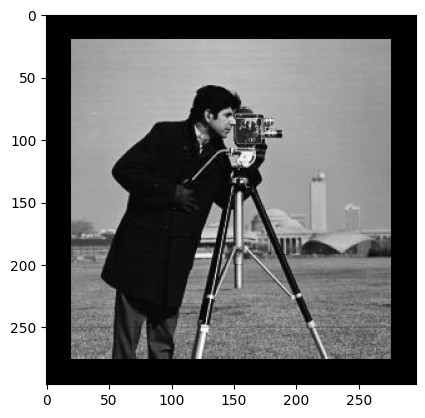

In [20]:
def zero_pad(X, pad):
  """
  This function applies the zero padding operation on all the images in the array X
  :param X input array of images; this array has a of rank 4 (batch_size, height, width, channels)
  :param pad the amount of zeros to be added around around the spatial size of the images
  """
  # hint you might find the function numpy.pad useful for this purpose
  # keep in mind that you only need to pad the spatial dimensions (height and width)
  # TODO your code here
  X = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0,0)), 'constant')
  return X

# load the image using Pillow
img = cv2.imread('cameraman.jpg', cv2.IMREAD_GRAYSCALE)
img = np.asarray(img)

# TODO your code here
# pad and display the cameraman.jpg image
# (if you are using matplotlib to display the image, use cmap='gray' in the imshow function)
img = np.reshape(img, (1, img.shape[0], img.shape[1], 1))
img = zero_pad(img, 20)
img = img.reshape((img.shape[1], img.shape[2]))
plt.imshow(img, cmap='gray')

In [21]:
def convolution(X, W, bias, pad, stride):
  """
  This function applied to convolution operation on the input X of shape (num_samples, iH, iW, iC)
  using the filters defined by the W (filter weights) and  (bias) parameters.

  :param X - input of shape (num_samples, iH, iW, iC)
  :param W - weights, numpy array of shape (fs, fs, iC, k), where fs is the filter size,
    iC is the depth of the input volum and k is the number of filters applied on the image
  :param biases - numpy array of shape (1, 1, 1, k)
  :param pad - hyperparameter, the amount of padding to be applied
  :param stride - hyperparameter, the stride of the convolution
  """

  # 0. compute the size of the output activation map and initialize it with zeros

  num_samples = X.shape[0]
  iW = X.shape[2]
  iH = X.shape[1]
  f = W.shape[0]

  # TODO your code here
  # compute the output width (oW), height (oH) and number of channels (oC)
  oW = (iW + 2 * pad - f) // stride + 1
  oH = (iH + 2 * pad - f) // stride + 1
  oC = W.shape[-1]
  # initialize the output activation map with zeros
  activation_map = np.zeros((num_samples, oH, oW, oC))
  # end TODO your code here

  # 1. pad the samples in the input
  # TODO your code here, pad X using pad amount
  X_padded = zero_pad(X, pad)
  # end TODO your code here

  # go through each input sample
  for i in range(num_samples):
    # TODO: get the current sample from the input (use X_padded)
    X_i = X_padded[i]
    # end TODO your code here

    # loop over the spatial dimensions
    for y in range(oH):
      # TODO your code here
      # compute the current ROI in the image on which the filter will be applied (y dimension)
      # tl_y - the y coordinate of the top left corner of the current region
      # br_y - the y coordinate of the bottom right corner of the current region
      tl_y = y * stride
      br_y = tl_y + f
      # end TODO your code here

      for x in range(oW):
        # TODO your code here
        # compute the current ROI in the image on which the filter will be applied (x dimension)
        # tl_x - the x coordinate of the top left corner of the current region
        # br_x - the x coordinate of the bottom right corner of the current region
        tl_x = x * stride
        br_x = tl_x + f
        # end TODO your code here

        for c in range(oC):
            # select the current ROI on which the filter will be applied
            roi = X_padded[i, tl_y: br_y, tl_x: br_x, :]
            w = W[:, :, :, c]
            b = bias[:, :, :, c]

            # TODO your code here
            # apply the filter with the weights w and bias b on the current image roi

            # A. compute the elemetwise product between roi and the weights of the filters (np.multiply)
            a = roi * w
            # B. sum across all the elements of a
            a = np.sum(a)
            # C. add the bias term
            a = a + b

            # D. add the result in the appropriate position of the output activation map
            activation_map[i, y, x, c] = a
            # end TODO your code here
        assert(activation_map.shape == (num_samples, oH, oW, oC))
  return activation_map



np.random.seed(10)
# 100 samples of shape (13, 21, 4)
X = np.random.randn(100, 13, 21, 4)

# 8 filters (last dimension) of shape (3, 3)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)

am = convolution(X, W, b, pad=1, stride=2)
print("am's mean =\n", np.mean(am))
print("am[1, 2, 3] =\n", am[3,2,1])


am's mean =
 -0.4284130223223714
am[1, 2, 3] =
 [ 1.78081902 -6.51813947 -4.35815226 -2.91158344  1.84016713 -3.72264278
 -8.32761753 -3.22778695]


Expected output:

am's mean =
 -0.42841306

am[1, 2, 3] =
 [ 1.780819  -6.5181394 -4.3581524 -2.9115834  1.8401672 -3.722643
 -8.327618  -3.227787 ]

Now let's analyse the effect of applying some well known filters used in image processing.

### Low pass filters
Low pass filters are used to keep the low frequency information within an, while reducing the high frequency information. These filters are the basis of image smoothing.

Two well known low pass filters are the _mean filter_ and the _Gaussian filter_.

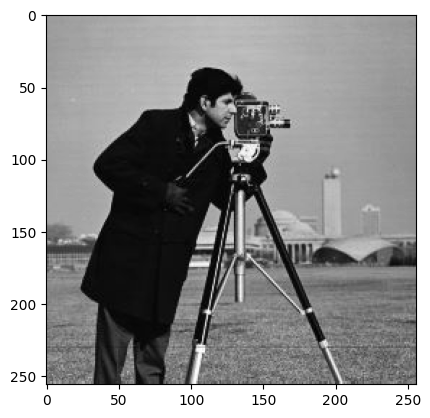

In [22]:
image = cv2.imread('cameraman.jpg', cv2.IMREAD_GRAYSCALE)
image = np.expand_dims(image, axis=-1)

# X contains a single image sample
X = np.expand_dims(image, axis=0)

plt.imshow(image, cmap='gray')

Text(0.5, 1.0, 'Gaussian filtered')

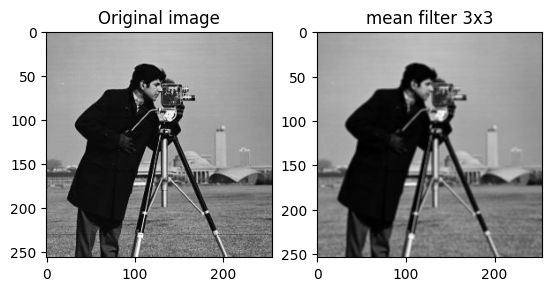

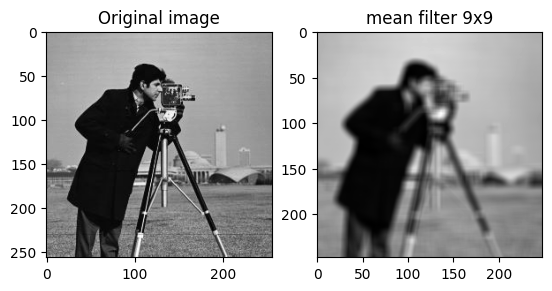

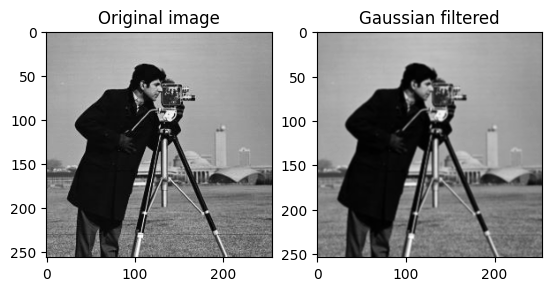

In [ ]:
############################################################
# MEAN FILTER
############################################################

bias = np.asarray([0])
bias = bias.reshape((1, 1, 1, 1))

mean_filter_3 = np.ones(shape=(3, 3, 1, 1), dtype=np.float32)
mean_filter_3 = mean_filter_3/9.0

mean_filter_9 = np.ones(shape=(9, 9, 1, 1), dtype=np.float32)
mean_filter_9 = mean_filter_9/81.0

mean_3x3 = convolution(X, mean_filter_3, bias, pad=0, stride=1)
mean_9x9 = convolution(X, mean_filter_9, bias, pad=0, stride=1)

plt.figure(0)
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mean_3x3[0, :, :, 0], cmap='gray')
plt.title('mean filter 3x3')

plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mean_9x9[0, :, :, 0], cmap='gray')
plt.title('mean filter 9x9')


############################################################
# GAUSSIAN FILTER
############################################################

gaussian_filter = np.asarray(
    [[1, 2, 1],
     [2, 4, 2],
     [1, 2, 1]],
     dtype=np.float32
)
gaussian_filter = gaussian_filter.reshape(3, 3, 1, 1)
gaussian_filter = gaussian_filter/16.0

gaussian_smoothed = convolution(X, gaussian_filter, bias, pad=0, stride=1)

plt.figure(3)
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(gaussian_smoothed[0,:,:,0], cmap='gray')
plt.title('Gaussian filtered')


__Optional__: Now load a color image and apply the mean filtering and Gaussian filtering on this color image.
Not much changes at the call of the convolution operation, you just need to "play" with the convolutional kernels configurations.

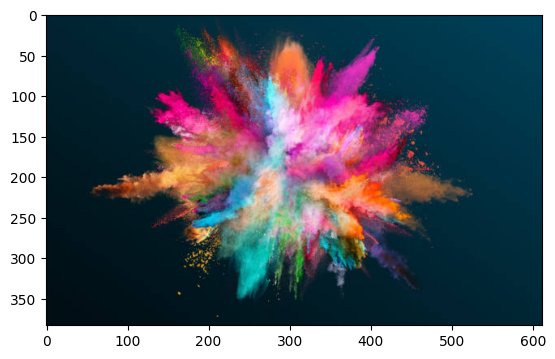

In [ ]:
color = cv2.imread('color.jpg')
color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
plt.imshow(color)

Text(0.5, 1.0, 'Gaussian filtered')

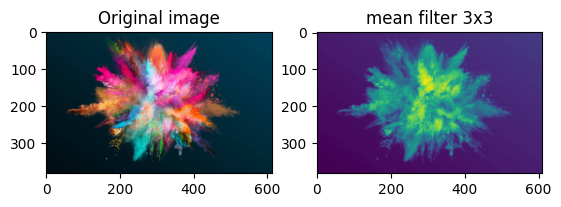

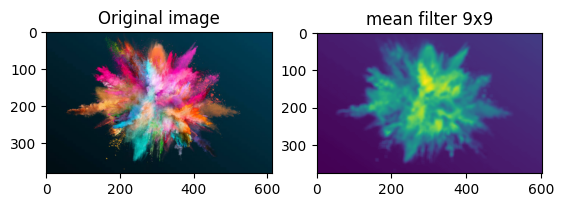

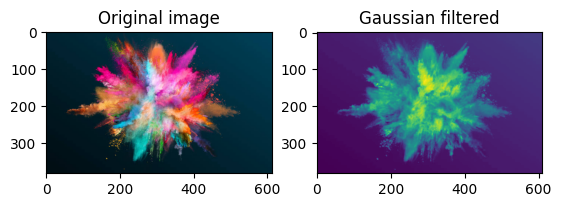

In [ ]:
# TODO your code here
############################################################
# MEAN FILTER
############################################################

bias = np.asarray([0])
bias = bias.reshape((1, 1, 1, 1))

mean_filter_3 = np.ones(shape=(3, 3, 1, 1), dtype=np.float32)
mean_filter_3 = mean_filter_3/9.0

mean_filter_9 = np.ones(shape=(9, 9, 1, 1), dtype=np.float32)
mean_filter_9 = mean_filter_9/81.0

mean_3x3 = convolution(X, mean_filter_3, bias, pad=0, stride=1)
mean_9x9 = convolution(X, mean_filter_9, bias, pad=0, stride=1)

plt.figure(0)
plt.subplot(1, 2, 1)
plt.imshow(color)
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mean_3x3[0].squeeze())
plt.title('mean filter 3x3')

plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(color)
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mean_9x9[0])
plt.title('mean filter 9x9')


############################################################
# GAUSSIAN FILTER
############################################################

gaussian_filter = np.asarray(
    [[1, 2, 1],
     [2, 4, 2],
     [1, 2, 1]],
     dtype=np.float32
)
gaussian_filter = gaussian_filter.reshape(3, 3, 1, 1)
gaussian_filter = gaussian_filter/16.0

gaussian_smoothed = convolution(X, gaussian_filter, bias, pad=0, stride=1)

plt.figure(3)
plt.subplot(1, 2, 1)
plt.imshow(color)
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(gaussian_smoothed[0].squeeze())
plt.title('Gaussian filtered')


### High pass filters

On the other hand, high pass filters are used to highlight the high frequency information in an image (edges, abrupt changes in intensities).

One of the most commonly used high pass filters is the Sobel kernel (depicted below). These filters can be seen as discrete differentiation operators, and they compute an approximation of the gradient (on the horizontal or vertical direction) of the image intensity function.

<img src="https://i.ytimg.com/vi/W7OpxFbrD84/maxresdefault.jpg" width=300px/>

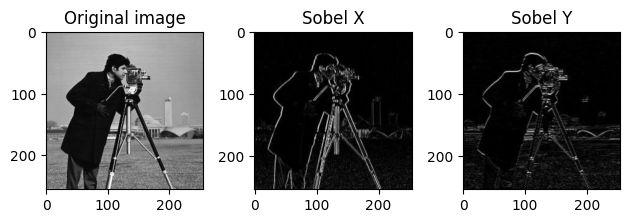

In [ ]:
sobel_horiz = np.asarray([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])

sobel_vert = sobel_horiz.T

sobel_horiz = np.reshape(sobel_horiz, (3, 3, 1, 1))
sobel_vert = np.reshape(sobel_vert, (3, 3, 1, 1))

sobel_x = convolution(X, sobel_horiz, bias, 0, 1)
sobel_y = convolution(X, sobel_vert, bias, 0, 1)


plt.subplot(1, 3, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(sobel_x[0,:,:,0])/np.abs(np.max(sobel_x[0,:,:,0]))*255, cmap='gray')
plt.title('Sobel X')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(sobel_y[0,:,:,0])/np.abs(np.max(sobel_y[0,:,:,0]))*255, cmap='gray')
plt.title('Sobel Y')
plt.tight_layout()


# Convolutional Neural Networks in pytorch


In this laboratory, you'll be using convolutional neural networks (CNNs) to perform image classification in torch.
You'll follow two approaches:
- First, you'll design, implement, and train a simple network **from scratch**. However, in practice, you won't get to train an entire CNN from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, the norm is to pre-train a CNN on a very large dataset and then use these weights as an initialization or a fixed feature extractor for the task of interest (transfer learning).
- Therefore, in the second part you'll use **transfer learning** to fine-tune an already trained model on your dataset. Transfer learning is a machine learning technique where a model pre-trained on one task is adapted to a different, but related, task. This approach leverages the knowledge and features learned during the initial training to improve performance and reduce data requirements for the new task, making it more efficient and effective.


The main pipeline when training a neural network model is:
1. "Get one with the data". Analyze your input images,
2. Define the model (start with something simple in the beginning)
3. Define the training setup
4. Train the model
5. Test and *analyze* the results.
*Repeat the steps 2-5*


# 1. Datasets and data loaders


You will be working with the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which is a 37 category pet dataset with roughly 200 images for each class. The images have large variations in scale, pose, and lighting, and they are annotated with the breed of the pet (37 classes), the head ROI, and pixel-level trimap segmentation.


*Datasets* and *DataLoader* are the core pytorch data structures for interacting with your data. Ideally, you would want your data handling code to be completely decoupled from the model training and testing code (you'll often need to evaluate your model on different datasets).


``torch.utils.data.Dataset`` stores the actual information about the dataset (the samples and their corresponding ground truth labels), while the torch.``utils.data.DataLoader`` wraps an iterable around the dataset, allowing easy access to the data, automatic batching, and multi-process data loading).


For now, you'll use the OxfordPets dataset implementation from [torchvision](https://pytorch.org/vision/stable/generated/torchvision.datasets.OxfordIIITPet.html), but next time you'll be learning how you can create your own custom dataset and how to configure data loaders.
torchvision is a popular package that comprises popular datasets, model architectures, and common image transformations for computer vision.


Transforms are common image transformations available in the ``torchvision.transforms`` module and can be used to preprocess and augment the input data. They can be chained together using *Compose*.
You can also use it to augment your data.
Image augmentation generates similar but distinct training examples after a series of random changes to the training images, and can help reduce overfitting.




```
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


```

100%|██████████| 791918971/791918971 [00:22<00:00, 35168718.56it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16142194.60it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


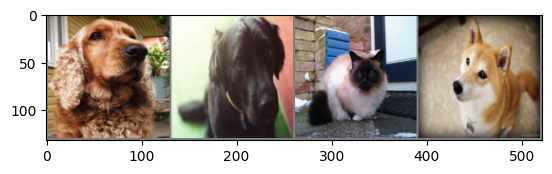

In [6]:
# TODO you code here
# - create an object of type torchvision.datasets.OxfordIIITPet, download it
# - torch.utils.data.DataLoader object
# - display some samples
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose(
    [transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.OxfordIIITPet(root='./data', split="trainval",
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.OxfordIIITPet(root='./data', split="test",
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))




# 2. The Convolutional Neural Network

## Convolutional Neural Networks for scratch

Check the tutorial from reference [[2]](#scrollTo=my1Fk-G5KKmz&line=2&uniqifier=1).

You'll define your convolutional neural network by extending the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, which is the base class for all the neural network modules.
In the constructor, you define the layers (and their properties) that comprise your module. ``torch.nn`` [package](https://pytorch.org/docs/stable/nn.html) provides classes for the basic layers of a CNN.

The function that you need to override is the _forward()_ function in which you specify computation performed at every call (i.e. how are layers chained and how does the data flow over the computational graph). In other words, this defines the forward pass through your model.



In [7]:
# TODO your code here: define a simple CNN model, pass a single example through the model
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 37)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Transfer learning


Check the tutorial from reference [[3]](#scrollTo=my1Fk-G5KKmz&line=2&uniqifier=1).


The ``torchvision`` module provides the implementation and pre-trained weights for common neural network architectures.
For example, to load the resnet18 architecture and its weights (after training on ImageNet, you can use:


```[python]
from torchvision.models import resnet18, ResNet18_Weights


# Using pretrained weights:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
```

 Remember from the first lab, that when using a pre-trained model you must preprocess to the image as the images used for training the model. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs. Each architecture uses a different preprocessing technique, so there is no standard way to achieve this.


#### Note (transfer learning training)
 In the tutorial, you will notice that the authors use model.train() and model.eval() in the training loop. These functions "tell" the model how to act when it is being run. In the next lectures, you will learn that some layers (such as dropout, batch normalization, and so on) behave differently during train and evaluation, and hence the model will produce unexpected results if run in the wrong mode. So don't forget these steps.


 To freeze the weights of the model and train only the rest, you can set requires_grad of the parameters you want to freeze to False.
```
for param in model.features.parameters():
    param.requires_grad = False
```


On the other hand, the ``torch.no_grad()``context manager that we used in the prvious lab  is used to prevent calculating gradients in the following code block. Usually it is used when you evaluate your model and don’t need to call backward() to calculate the gradients and update the corresponding parameters. In this mode, the result of every computation will have ``requires_grad=False``, even when the inputs have ``requires_grad=True``.



In [11]:
# TODO : your code here
# get a pretrained torchvision module, change the last layer,  pass a single example through the model
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.models import MobileNet_V2_Weights

# Load pre-trained MobileNetV2
mobile_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

# Modify the last layer for the number of classes in Oxford-IIIT Pet dataset
num_ftrs = mobile_model.classifier[-1].in_features
mobile_model.classifier[-1] = nn.Linear(num_ftrs, 37)  # Change the last layer for 37 classes in Oxford-IIIT Pet

# Set the model to evaluation mode
mobile_model.eval()

dataloader = DataLoader(testset, batch_size=1, shuffle=True)

# Get a single example from the dataset
for inputs, labels in dataloader:
    input_batch = inputs
    true_label = testset.classes[labels.item()]
    break

# Make a prediction
with torch.no_grad():
    output = mobile_model(input_batch)

# The output is the raw scores, you may want to apply softmax if you need probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Print the predicted class and its probability
predicted_class = torch.argmax(probabilities).item()
predicted_prob = probabilities[predicted_class].item()
predicted_label = testset.classes[predicted_class]

print(f"Predicted Class: {predicted_class}")
print(f"Probability: {predicted_prob:.4f}")
print(f"True label: {true_label} vs Predicted label: {predicted_label}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 41.6MB/s]


Predicted Class: 35
Probability: 0.0610
True label: Yorkshire Terrier vs Predicted label: Wheaten Terrier


# 3. Training the model


For training, we need to define a loss function and an optimizer. We'll cover optimizers next time, in this laboratory we'll just stick to stochastic gradient descent.


Let's first define some concepts:
- epoch: an epoch defines a pass through the entire training dataset. The number of epochs (passes of the entire training dataset the machine learning algorithm has completed) is a hyperparameter of your model. An epoch consists of one or more batches.
- batch:  a batch defines how many samples your model "sees" before updating its weights. In other words, the batch size is the number of samples that will be passed through to the network at one time during its training.
- sample: a sample is just a single training example.


As you saw in the previous laboratory, a typical training loop looks like this:
```


optimizer - the chosen optimizer. It holds the current state of the model and will update the parameters based on the computed gradients. Notice that in the constructor of the optimizer you need to pass the parameters of your model and the learning rate.
criterion - the chosen loss function.


for epoch in range(num_epochs):  # num_epochs is a hyperparameter that specifies when is the training process


    running_loss = 0.0
    for i, data in enumerate(dataloader, 0): # iterate over the dataset, now we use data loaders
        # get a batch of data (inputs and their corresponding labels)
        inputs, labels = data


        # IMPORTANT! set the gradients of the tensors to 0. by default torch accumulates the gradients on subsequent backward passes
        # if you omit this step, the gradient would be a combination of the old gradient, which you have already used to update the parameters
        optimizer.zero_grad()


        # perform the forward pass through the network
        outputs = net(inputs)
       
        # apply the loss function to determine how your model performed on this batch
        loss = criterion(outputs, labels)

        # start the backprop process. it will compute the gradient of the loss with respect to the graph leaves
        loss.backward()


        # update the model parameters by calling the step function
        optimizer.step()


```



In [15]:
# TODO code to train your model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
num_epochs = 2

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # perform the forward pass through the network
        outputs = net(inputs)

        # apply the loss function to determine how your model performed on this batch
        loss = criterion(outputs, labels)

        # start the backprop process. it will compute the gradient of the loss with respect to the graph leaves
        loss.backward()

        # update the model parameters by calling the step function
        optimizer.step()

print('Finished Training')

Finished Training


Finished Training


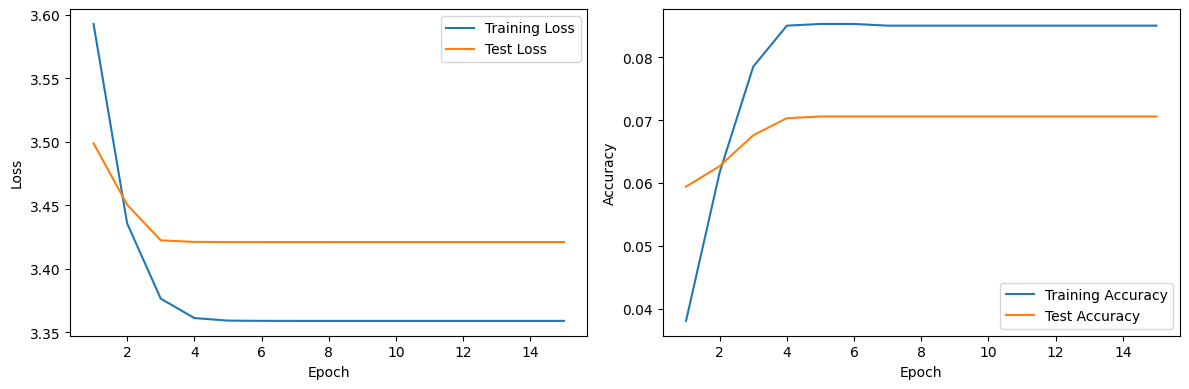

Finished Training


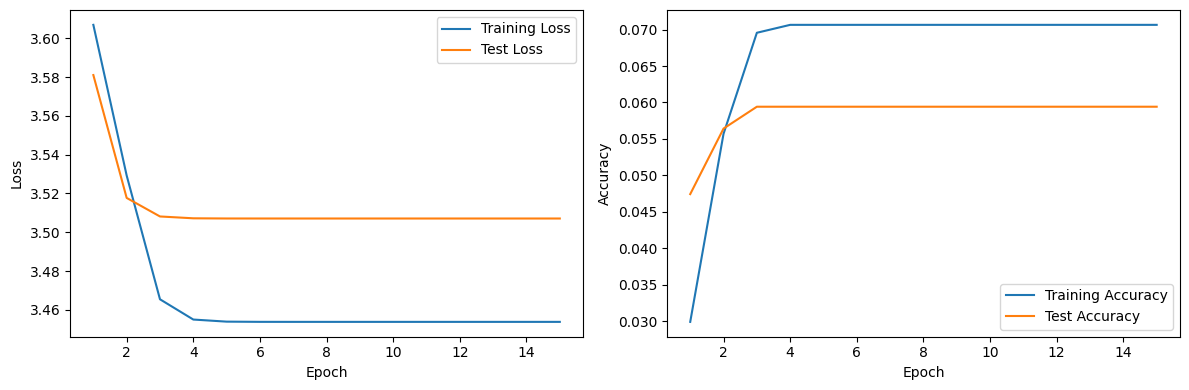

Finished Training


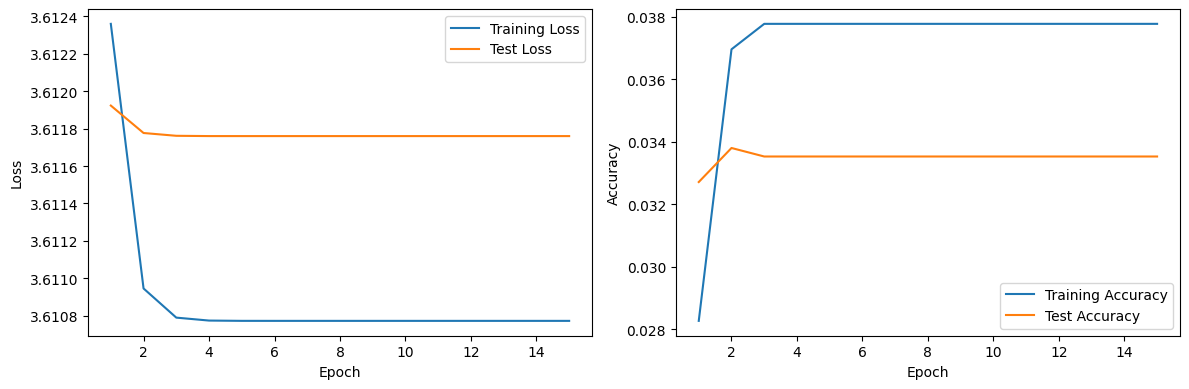

In [8]:
# TODO code to train your model
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

# Function to train the model with a given learning rate
def train_model(net, lr, num_epochs=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # Learning rate scheduler

    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss_history.append(running_loss / len(trainloader))
        train_accuracy_history.append(correct_train / total_train)

        # Validation phase
        net.eval()
        with torch.no_grad():
            test_loss = 0.0
            correct_test = 0
            total_test = 0
            for data in testloader:
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

            test_loss_history.append(test_loss / len(testloader))
            test_accuracy_history.append(correct_test / total_test)

        net.train()
        scheduler.step()

    print('Finished Training')

    # Plotting the results
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Training Loss')
    plt.plot(epochs, test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_history, label='Training Accuracy')
    plt.plot(epochs, test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Experiment with different learning rates
learning_rates = [0.1, 0.01, 0.001]
for lr in learning_rates:
    net = Net()  # Assuming Net is your neural network class
    train_model(net, lr, 15)



Now let's examine the effect of the learning rate over the training process.

- First, create two plots: one in which you plot, for each epoch, the loss values on the training and the test data (two series on the same graph), and another one in which you plot, for each epoch, the accuracy values on the training and the test data.
- Experiment with different values for the learning rate.
- Then, experiment with a torch.optim.lr_scheduler to adjust the learning rate during the training process [doc](!https://pytorch.org/docs/stable/optim.html).

```
optimizer = SGD(model, lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

for epoch in range(num_epochs):
    for input, target in dataset:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    # apply the learning rate scheduler
    scheduler.step()
```

Plot the learning curves for all the training that you performed.
Fill in the table to compare the accuracy of your trained models.

| Model              | lr config            | accuracy  train| accuracy test |
| -----------        | -----------          | ------         | -----         |
| Model              | lr info              |   acc          |acc            |
| Model              | lr info              |   acc          |acc            |


You can work in teams and each team will train the model with a different setup.



# Using the GPU

``torch`` is designed to allow for computation both on CPU and on GPU.
If your system has a GPU and the required libraries configured for torch compatibility, the cell below will print information about its state.

If you are running your code on colab, you can enable GPU computation from: Runtime->Change Runtime type -> T4 GPU

In [1]:
import torch
if torch.cuda.is_available():
    !nvidia-smi
else:
    print("NO GPU ☹️")

Sun Dec 10 14:57:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now we can start to use accelaration.
You now need to explictly specify on which device your tensors reside. You can
move all of the model's parameters `.to` a certain device (the GPU)
and also move the data on the same device there as well
before applying the model and calculating the loss.

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net.to(device)
loss_fn(net(x.to(device)), y.to(device))

NameError: ignored

#Useful references

- [1] [a "recipe" ](http://karpathy.github.io/2019/04/25/recipe/)  when you will start training artifcial neural networks;
- [2] [Defining a CNN](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) in torch;
- [3] [Transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) in torch;
- [4] [model debugging](https://developers.google.com/machine-learning/testing-debugging/common/overview).

# <font color='red'> Optional </font>  
## Pooling

The pooling layer is used to reduce the spatial dimension of the activation maps, and thus the computational burden. It has no learnable parameters and it operates individually across each input channel and resizes it spatially.

The two most common types of pooling are max pooling and average pooling.


The hyperparameters of a pooling layer are:
- the filter size F (usually this is an odd value);
- the stride S (or the step used when sliding across the input volume);

Given an input volume of shape  ($H_i$, $W_i$, $D$), the convolutional layer will produce an output of shape ($H_o$, $W_o$, $D$), where:

\begin{equation}
W_o = \frac{W_i - F}{S} + 1
\end{equation}

\begin{equation}
H_o = \frac{H_i - F}{S} + 1
\end{equation}

An illustration of the pooling operation is depicted in the image below:

![picture](https://www.researchgate.net/profile/Alla-Eddine-Guissous/publication/337336341/figure/fig15/AS:855841334898691@1581059883782/Example-for-the-max-pooling-and-the-average-pooling-with-a-filter-size-of-22-and-a.jpg)

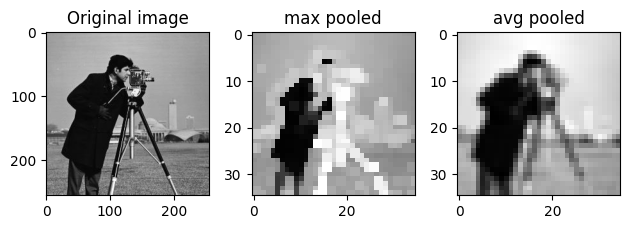

In [23]:
def pooling(X, filter_size, stride, type):
    """
    Implements the pooling operation

    :param X - input volume of shape (num_samples, H, W, C)
    :param filter_size - the size of the pooling
    :param stride - the stride of the pooling operation
    :param type - can be 'max' or 'avg'; the type of the pooling operation to apply

    Returns the output of the pooling operation.
    """
    # TODO your code here implement the pooling operation
    # you can inspire yourself from the convolution implementation on how to organize your code
    num_samples = X.shape[0]
    iW = X.shape[2]
    iH = X.shape[1]

    oW = (iW - filter_size) // stride + 1
    oH = (iH - filter_size) // stride + 1
    oC = X.shape[-1]

    activation_map = np.zeros((num_samples, oH, oW, oC))

    for i in range(num_samples):
        X_i = X[i]

        for y in range(oH):
          tl_y = y * stride
          br_y = tl_y + filter_size

          for x in range(oW):
              tl_x = x * stride
              br_x = tl_x + filter_size

              roi = X[i, tl_y : br_y, tl_x : br_x, :]
              newVal = None
              if type == 'max':
                  newVal = np.max(roi)
              else:
                  newVal = np.average(roi)

              activation_map[i, y, x, :] = newVal
              assert(activation_map.shape == (num_samples, oH, oW, oC))
    return activation_map

# TODO your code here
# apply the pooling operation on a grayscale image and on a color image
# try different values for the stride and filter size. What do you observe?
maxpool = pooling(X, 13, 7, 'max')
avgpool = pooling(X, 13, 7, 'avg')
plt.subplot(1, 3, 1)
plt.imshow(X.squeeze(), cmap='gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.imshow(maxpool.squeeze(), cmap='gray')
plt.title('max pooled')
plt.subplot(1, 3, 3)
plt.imshow(avgpool.squeeze(), cmap='gray')
plt.title('avg pooled')
plt.tight_layout()